In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fileinput
import json
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
import scipy as sp



In [3]:
df = pd.read_json('Data/car_transactions.jl',lines=True)

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]
#cleaning dataset in case of incomplete entries
df = clean_dataset(df)

In [4]:

X = df[['frmdata','prim_damage','repair_cost','sec_damage','acv','odo','page','desc']]
Y = df[['price']]

#assigning x and y, will be adjusting both


In [5]:

##this code cell is very confusing, but basically removes desc and frimdata, adds make, model, fryear, toyear,location as datacolumns

makes = []
toyear = []
fryear = []
models = []
Location = []

print(X.columns)
##below code will go through frmdata, and make lists for make, toyear and fryear for splitting into multiple columns
for key, value in X.iterrows():
    makes.append(value[0]['Make'])
    toyear.append(value[0]['ToYear'])
    fryear.append(value[0]['FrYear'])
    Location.append(value[7].split("Location:",1)[1])
#this for loop is for checking the make and desc for the model name to find the correct model and append it, if not gives notfound    
    modelandyear = value[7].split(";",1)[0]
    model = modelandyear[4:] #truncating year from the model type
    models.append(model)
    

            

#deleting and assigning our columns    
X = X.assign(Location = Location)
X = X.assign(make = makes)
X = X.assign(toyear = toyear)
X = X.assign(fryear = fryear)
X = X.assign(model = models)
X = X.drop('frmdata',axis=1)
X = X.drop('desc',axis=1)
print(X.columns)

#now our X values look like we want them to!

#plt.plot(X.frmdata,Y.price)

Index(['frmdata', 'prim_damage', 'repair_cost', 'sec_damage', 'acv', 'odo',
       'page', 'desc'],
      dtype='object')
Index(['prim_damage', 'repair_cost', 'sec_damage', 'acv', 'odo', 'page',
       'Location', 'make', 'toyear', 'fryear', 'model'],
      dtype='object')


In [6]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
#gonna convert from string to numerical monies
def encodemoney(Y,index):
    money = []
    for key, value in Y.iterrows():
        if isinstance(value[index], np.floating):
            money.append(value[index])
        if value[index] == "" or value[index] is None:
            money.append(0)
        else:
            length = len(value[index])
            #print(value[index])
            #print(length)
            if value[index][length-3] == 'C':
                ans = value[index].strip("CAD")
                money.append(.79 * locale.atof(ans.strip("$")))
            else:
                ans = value[index].strip("USD")
                money.append(locale.atof(ans.strip("$")))
    return money


Y = Y.assign(price = encodemoney(Y,0))

X = X.assign(repair_cost = encodemoney(X,1))
#encoding money for nessecary columns          

In [7]:
X = X.assign(acv = encodemoney(X,3))

In [61]:


df = X.assign(price = Y)
#gimmick to put prices into X so can get samples for Y too for training

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = .2)

X_test = test[['prim_damage', 'repair_cost', 'sec_damage', 'acv', 'odo', 'page',
       'Location', 'make', 'toyear', 'fryear', 'model']]
X_train = train[['prim_damage', 'repair_cost', 'sec_damage', 'acv', 'odo', 'page',
       'Location', 'make', 'toyear', 'fryear', 'model']]
Y_test = test[['price']]
Y_train = train[['price']]


##adjust parameters of the model so its not computationally impossible
#xchoice  = input("choose a column")
xchoice = [
       'acv','Location' ]
X_test = X_test[xchoice]
X_train = X_train[xchoice]

##encoding our x values
le = preprocessing.OneHotEncoder()
le.fit(X[xchoice])
X_test = le.transform(X_test)     
X_train = le.transform(X_train) 


#dont need to encode y, is money value
    


In [62]:




from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

Y_trainnp = Y_train.to_numpy() #some models dont take pddataframes


#create models and run it from here on out

In [67]:
model0 = LinearRegression().fit(X_train,Y_train)

In [68]:
print("linear regression training score")
print(model0.score(X_train, Y_train ))
print("linear regression test score")
print(model0.score(X_test, Y_test))

linear regression training score
0.7111310119246923
linear regression test score
0.3729385191376573


In [65]:
model1 = Ridge().fit(X_train,Y_trainnp)

In [66]:
print("Ridge training score")
print(model1.score(X_train, Y_train ))
print("Ridge test score")
print(model1.score(X_test, Y_test))

Ridge training score
0.6150850310465572
Ridge test score
0.3728072161430348


In [45]:
model2 = SGDRegressor().fit(X_train,Y_trainnp)

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [46]:
print("SGD regressor score")
print(model2.score(X_train, Y_train ))
print("SGD regressor test score")
print(model2.score(X_test, Y_test))

SGD regressor score
0.12720454795098035
SGD regressor test score
0.12489273643462784


In [63]:
from sklearn.linear_model import RANSACRegressor
model3 = RANSACRegressor().fit(X_train,Y_trainnp)

In [64]:
print("RANSAC training score")
print(model3.score(X_train, Y_train ))
print("RANSAC  test score")
print(model3.score(X_test, Y_test))

RANSAC training score
0.3135028933891013
RANSAC  test score
0.21572212014796854


Text(0.5, 1.0, 'histogram of prices, truncated to remove some outliers above 200000')

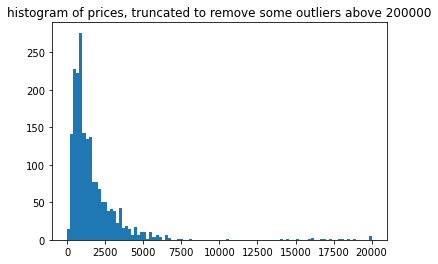

In [86]:
plot = Y.head(2000)
plt.hist(plot,100, range = (0,20000))
plt.xlabel = "dollars, 1000 bins"
plt.ylabel = "number of cars"
plt.title("histogram of prices, truncated to remove some outliers above 200000")

Text(0.5, 1.0, 'scatterplot of prices at different locations')

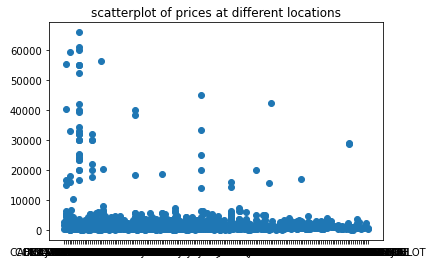

In [93]:
plot1 = X['Location'].head(2000)

plt.scatter(plot1,Y.head(2000))
plt.title("scatterplot of prices at different locations")